# BRW Estimation

Replication code of the BRW shock by Bu, Wu, and Rogers (2021).

In [143]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from linearmodels.iv import IV2SLS
from matplotlib.ticker import MaxNLocator

## 1. Calculating the difference of the 2-year Treasury series (DGS2)

Load the data and rename columns

In [144]:
data = pd.read_excel(r"C:\Users\Alysson\Documents\GitHub\Monetary-Shocks\Europe\DGS5.xls")
data.rename(columns={"observation_date": "date"}, inplace=True)
data.sort_values(by='date', inplace=True)
data.replace(0, method='ffill', inplace=True)

Convert date to datetime format and create additional date-related columns

In [145]:
data["date"] = pd.to_datetime(data["date"])
data["year"] = data["date"].dt.year
data["month"] = data["date"].dt.month
data["day"] = data["date"].dt.day
data["mdate"] = data["date"].dt.to_period("M")

Filter data for the specified period (up to September 2019 - Cut-off date used for the estimation in the research paper.)

In [146]:
data = data[data["mdate"] <= pd.Period("2018-12")]
data = data[data["mdate"] >= pd.Period("1994-01")]

Calculate the difference of the series (dgs_d)

In [147]:
data["dgs_d"] = data["DGS" + str(maturity)] - data["DGS" + str(maturity)].shift(1)

Set "mdate" as the index and convert it to a time series

In [148]:
data.set_index("mdate", inplace=True)
data.index = pd.to_datetime(data.index.to_timestamp())

Drop unnecessary columns

In [149]:
data.drop(columns=["year", "month", "day"], inplace=True)
data.head()

,date,DGS2,dgs_d
mdate,,,
2000-11-01,2000-11-30,5.314,NaN
2000-12-01,2000-12-01,5.336,0.022
2000-12-01,2000-12-04,5.296,-0.040
2000-12-01,2000-12-05,5.267,-0.029
2000-12-01,2000-12-06,5.198,-0.069


Save the resulting DataFrame to a new file

In [150]:
data.to_pickle("temp.pkl")

## 2. Adding FOMC dates

Load the FOMC dates from the Excel file

In [151]:
fomc_dates = pd.read_excel("C:/Users/Alysson/Documents/GitHub/Monetary-Shocks/Europe/BCEdate.xlsx")
fomc_dates.rename(columns={"date": "FOMC_date"}, inplace=True)

Convert date to datetime format and create additional date-related columns

In [152]:
fomc_dates["FOMC_date"] = pd.to_datetime(fomc_dates["FOMC_date"])
fomc_dates["year"] = fomc_dates["FOMC_date"].dt.year
fomc_dates["month"] = fomc_dates["FOMC_date"].dt.month
fomc_dates["day"] = fomc_dates["FOMC_date"].dt.day
fomc_dates["mdate"] = fomc_dates["FOMC_date"].dt.to_period("M")




Drop unnecessary columns

In [153]:
fomc_dates.drop(columns=["year", "month", "day"], inplace=True)

Load the previous DataFrame "temp.dta" 

In [154]:
temp_data = pd.read_pickle("temp.pkl")

Merge the two DataFrames on the 'date' column

In [155]:
merged_data = pd.merge(temp_data, fomc_dates, how="inner", left_on="date", right_on="FOMC_date")

Drop rows where 'q' is missing (denoted as NaN)

In [156]:
merged_data = merged_data.dropna(subset=["q"])

Replace missing values (NaN) in 'q' with 0

In [157]:
merged_data["q"].fillna(0, inplace=True)
merged_data.head()

,date,DGS2,dgs_d,FOMC_date,q,mdate
0,2004-01-08,3.625,-0.019,2004-01-08,1,2004-01
1,2004-01-15,3.563,0.028,2004-01-15,0,2004-01
2,2004-02-05,3.583,0.000,2004-02-05,1,2004-02
3,2004-02-12,3.491,0.011,2004-02-12,0,2004-02
4,2004-03-04,3.447,-0.057,2004-03-04,1,2004-03


Save the merged DataFrame to a new file

In [158]:
merged_data.to_pickle("temp.pkl")

## 3. Estimation

Load the data from "feds200628.csv" 

In [159]:
yield_data = pd.read_excel(r"C:\Users\Alysson\Documents\GitHub\Monetary-Shocks\Europe\svensson_eu.xlsx")

Convert 'date' column to datetime format and keeping only necessary columns

In [160]:
yield_data['date'] = pd.to_datetime(yield_data['Date'], format='%Y-%m-%d')
yield_data.sort_values(by='date', inplace=True)
yield_data.loc[:, 'SVENY03':'SVENY10'] = yield_data.loc[:, 'SVENY03':'SVENY10'].fillna(method='ffill')

In [161]:
yield_data['year'] = yield_data['date'].dt.year
yield_data['month'] = yield_data['date'].dt.month
yield_data['day'] = yield_data['date'].dt.day
yield_data['date'] = pd.to_datetime(yield_data[['year', 'month', 'day']])
yield_data['mdate'] = yield_data['date'].dt.to_period('M')
yield_data = yield_data[['date', 'mdate'] + [col for col in yield_data.columns if col.startswith('SVENY')]]
yield_data = yield_data[yield_data['mdate'] >= pd.Period('1994-01')]

Create a list for all maturities of the treasuries

Calculate differences for each maturity

In [162]:
list_maturities = ["03", "01", "02", "05", "07", "10"]

for num in list_maturities:
    col_name = f'SVENY{num}'
    yield_data[f'{col_name}_d'] = yield_data[col_name].diff()
selected_columns = yield_data.iloc[:, -30:]

Create aligned_dgs_d column

In [163]:
data_complete = merged_data.merge(yield_data, on=['date','mdate'], how='inner')
data_complete.head()

,date,DGS2,dgs_d,FOMC_date,q,mdate,SVENY03,SVENY01,SVENY02,SVENY05,SVENY07,SVENY10,SVENY03_d,SVENY01_d,SVENY02_d,SVENY05_d,SVENY07_d,SVENY10_d
0,2004-09-09,3.551,-0.047,2004-09-09,0,2004-09,2.113858,2.681737,3.314657,4.523514,4.940338,5.254992,-0.017703,-0.071375,-0.095811,-0.073510,-0.053247,-0.036033
1,2004-10-07,3.479,0.023,2004-10-07,1,2004-10,2.115299,2.590555,3.175453,4.419274,4.872644,5.209055,-0.001812,-0.002787,-0.000170,0.012123,0.017410,0.021024
2,2004-10-14,3.333,-0.020,2004-10-14,0,2004-10,2.079713,2.464972,3.020053,4.322774,4.805850,5.157202,-0.007936,-0.029541,-0.035583,-0.020227,-0.013531,-0.010008
3,2004-11-04,3.284,-0.038,2004-11-04,1,2004-11,2.075293,2.459046,3.002293,4.315651,4.824634,5.194724,-0.001139,-0.002745,-0.002446,0.001330,0.002492,0.002555
4,2004-11-11,3.252,-0.054,2004-11-11,0,2004-11,2.113998,2.401098,2.904423,4.238377,4.749545,5.100333,-0.014839,-0.046016,-0.049416,-0.013963,-0.004749,-0.006321


### Step 1 - 2SLS

In [164]:
### Creating IV

mask_q0 = data_complete["q"] == 0
mask_q1 = data_complete["q"] == 1
data_complete["const"] = 1
data_complete["iv"] = data_complete[mask_q1]["dgs_d"]
data_complete.loc[mask_q0, "iv"] = -1 * data_complete.loc[mask_q0, "dgs_d"]

In [165]:
for num in list_maturities:
    col_name = f'SVENY{num}_d'
    model = IV2SLS(dependent=data_complete[col_name], endog=data_complete["dgs_d"], exog=data_complete[["const"]], instruments=data_complete["iv"])
    results = model.fit()
    data_complete[f"beta_hat{num}"]=results.params["dgs_d"]
    print(results)
data_complete.head()

                          IV-2SLS Estimation Summary                          
Dep. Variable:              SVENY03_d   R-squared:                     -0.0972
Estimator:                    IV-2SLS   Adj. R-squared:                -0.1008
No. Observations:                 313   F-statistic:                    0.7853
Date:                Fri, Dec 01 2023   P-value (F-stat)                0.3755
Time:                        16:19:59   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const         -0.0007     0.0043    -0.1654     0.8686     -0.0092      0.0077
dgs_d          0.3561     0.4018     0.8862     0.37

,date,DGS2,dgs_d,FOMC_date,q,mdate,SVENY03,SVENY01,SVENY02,SVENY05,...,SVENY07_d,SVENY10_d,const,iv,beta_hat03,beta_hat01,beta_hat02,beta_hat05,beta_hat07,beta_hat10
0,2004-09-09,3.551,-0.047,2004-09-09,0,2004-09,2.113858,2.681737,3.314657,4.523514,...,-0.053247,-0.036033,1,0.047,0.356111,0.43504,0.259534,0.151136,0.135107,0.084513
1,2004-10-07,3.479,0.023,2004-10-07,1,2004-10,2.115299,2.590555,3.175453,4.419274,...,0.017410,0.021024,1,0.023,0.356111,0.43504,0.259534,0.151136,0.135107,0.084513
2,2004-10-14,3.333,-0.020,2004-10-14,0,2004-10,2.079713,2.464972,3.020053,4.322774,...,-0.013531,-0.010008,1,0.020,0.356111,0.43504,0.259534,0.151136,0.135107,0.084513
3,2004-11-04,3.284,-0.038,2004-11-04,1,2004-11,2.075293,2.459046,3.002293,4.315651,...,0.002492,0.002555,1,-0.038,0.356111,0.43504,0.259534,0.151136,0.135107,0.084513
4,2004-11-11,3.252,-0.054,2004-11-11,0,2004-11,2.113998,2.401098,2.904423,4.238377,...,-0.004749,-0.006321,1,0.054,0.356111,0.43504,0.259534,0.151136,0.135107,0.084513


### Step 2 - Fama and MacBeth

In [166]:
data_complete = data_complete.loc[mask_q0]
maxt = len(data_complete)

aligned_dgs_d = []
for num in range(maxt):
    sveny_values = data_complete.iloc[num, data_complete.columns.get_loc("SVENY03_d"):data_complete.columns.get_loc("SVENY10_d") + 1].values.astype(float)
    beta_values = data_complete.iloc[num, data_complete.columns.get_loc("beta_hat03"):data_complete.columns.get_loc("beta_hat10") + 1].values.astype(float)

    # Adicionando uma constante à matriz independente (para o termo constante na regressão)
    X = sm.add_constant(beta_values)

    # Realizando a regressão usando o OLS do StatsModels
    model = sm.OLS(sveny_values, X)
    results = model.fit()

    # Imprimindo os coeficientes beta estimados
    aligned_dgs_d.append(results.params[1:])

data_complete["new_shock"]=aligned_dgs_d
data_complete["new_shock"] = data_complete["new_shock"].apply(lambda x: x[0])

In [167]:
data_complete

,date,DGS2,dgs_d,FOMC_date,q,mdate,SVENY03,SVENY01,SVENY02,SVENY05,...,SVENY10_d,const,iv,beta_hat03,beta_hat01,beta_hat02,beta_hat05,beta_hat07,beta_hat10,new_shock
0,2004-09-09,3.551,-0.047,2004-09-09,0,2004-09,2.113858,2.681737,3.314657,4.523514,...,-0.036033,1,0.047,0.356111,0.43504,0.259534,0.151136,0.135107,0.084513,-0.012676
2,2004-10-14,3.333,-0.020,2004-10-14,0,2004-10,2.079713,2.464972,3.020053,4.322774,...,-0.010008,1,0.020,0.356111,0.43504,0.259534,0.151136,0.135107,0.084513,-0.031254
4,2004-11-11,3.252,-0.054,2004-11-11,0,2004-11,2.113998,2.401098,2.904423,4.238377,...,-0.006321,1,0.054,0.356111,0.43504,0.259534,0.151136,0.135107,0.084513,-0.098607
6,2004-12-09,3.061,0.017,2004-12-09,0,2004-12,2.071418,2.282550,2.701955,3.914163,...,-0.086457,1,-0.017,0.356111,0.43504,0.259534,0.151136,0.135107,0.084513,0.228480
8,2005-01-20,3.097,0.040,2005-01-20,0,2005-01,2.092733,2.409514,2.826961,3.824399,...,0.060848,1,-0.040,0.356111,0.43504,0.259534,0.151136,0.135107,0.084513,-0.118934
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,2018-06-21,0.251,-0.013,2018-06-21,0,2018-06,-0.390591,-0.107171,0.247199,1.142921,...,-0.031233,1,0.013,0.356111,0.43504,0.259534,0.151136,0.135107,0.084513,0.215899
306,2018-08-02,0.342,-0.009,2018-08-02,0,2018-08,-0.343299,-0.020201,0.364457,1.283314,...,-0.012058,1,0.009,0.356111,0.43504,0.259534,0.151136,0.135107,0.084513,0.129070
308,2018-09-20,0.354,-0.005,2018-09-20,0,2018-09,-0.321582,0.004525,0.431140,1.440533,...,-0.064048,1,0.005,0.356111,0.43504,0.259534,0.151136,0.135107,0.084513,0.516991
310,2018-11-01,0.357,0.004,2018-11-01,0,2018-11,-0.327439,0.140668,0.633197,1.516626,...,0.058701,1,-0.004,0.356111,0.43504,0.259534,0.151136,0.135107,0.084513,-0.273670


### Renormalization

In [168]:
renormalization = sm.OLS(data_complete["dgs_d"], data_complete["new_shock"])
results_renormalization = renormalization.fit()
beta_estimado = results_renormalization.params["new_shock"]
data_complete["BRW_daily"]=data_complete["new_shock"]*beta_estimado 
#print(results_renormalization.summary())


In [169]:
BRW_regression = sm.OLS(data_complete["dgs_d"], data_complete["BRW_daily"])
results_BRW_regression = BRW_regression.fit()
print(results_BRW_regression.summary())

                                 OLS Regression Results                                
Dep. Variable:                  dgs_d   R-squared (uncentered):                   0.013
Model:                            OLS   Adj. R-squared (uncentered):              0.007
Method:                 Least Squares   F-statistic:                              2.077
Date:                Fri, 01 Dec 2023   Prob (F-statistic):                       0.152
Time:                        16:20:00   Log-Likelihood:                          294.70
No. Observations:                 157   AIC:                                     -587.4
Df Residuals:                     156   BIC:                                     -584.3
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

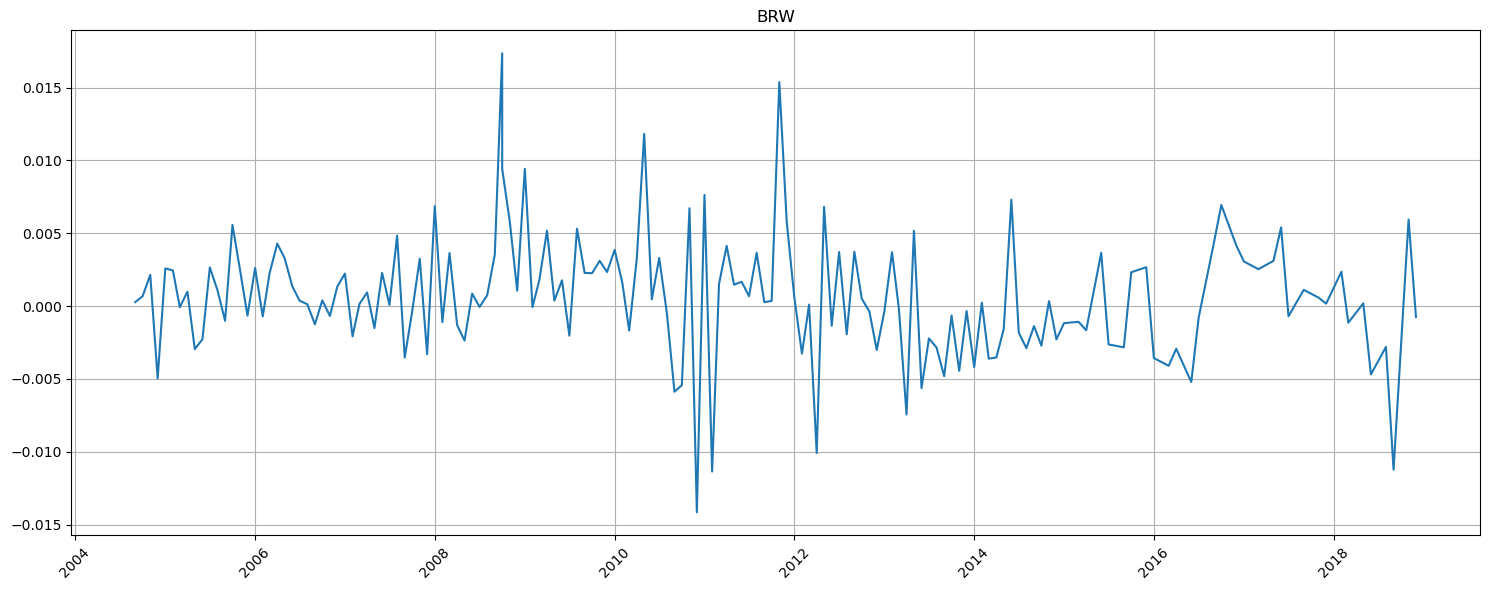

In [170]:
# Converter valores do tipo Period para datetime
mdate_values = data_complete["mdate"].dt.to_timestamp()
new_shock_values = data_complete["BRW_daily"]

# Criar um gráfico de linha
plt.figure(figsize=(15, 6))
plt.plot(mdate_values, new_shock_values)
plt.title("BRW")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [171]:
data_complete["BRW_daily"]

0      0.000275
2      0.000679
4      0.002143
6     -0.004965
8      0.002584
         ...   
304   -0.004691
306   -0.002805
308   -0.011234
310    0.005947
312   -0.000751
Name: BRW_daily, Length: 157, dtype: float64

In [172]:
# Definir a data de início e a data de término
start_date = pd.to_datetime("2004-10-14")
end_date = pd.to_datetime("2019-09-19")  # Especifique a data de término desejada

# Criar um intervalo de datas mensais até a data de término
date_range = pd.date_range(start=start_date, end=end_date, freq="M")

# Criar um DataFrame com a coluna de datas
data_monthly = pd.DataFrame({'mdate': date_range})

# Formatar as datas no estilo "1994-02"
data_monthly['mdate'] = data_monthly['mdate'].dt.strftime('%Y-%m')

columns = data_complete[['mdate', 'BRW_daily']]

columns.isetitem(columns.columns.get_loc('mdate'), columns['mdate'].dt.strftime('%Y-%m'))

data_monthly = data_monthly.merge(columns, on='mdate', how='left')
data_monthly['BRW_daily'].fillna(0, inplace=True)


# Imprimir as primeiras linhas do DataFrame
print(data_monthly)


       mdate  BRW_daily
0    2004-10   0.000679
1    2004-11   0.002143
2    2004-12  -0.004965
3    2005-01   0.002584
4    2005-02   0.002451
..       ...        ...
175  2019-04   0.000000
176  2019-05   0.000000
177  2019-06   0.000000
178  2019-07   0.000000
179  2019-08   0.000000

[180 rows x 2 columns]


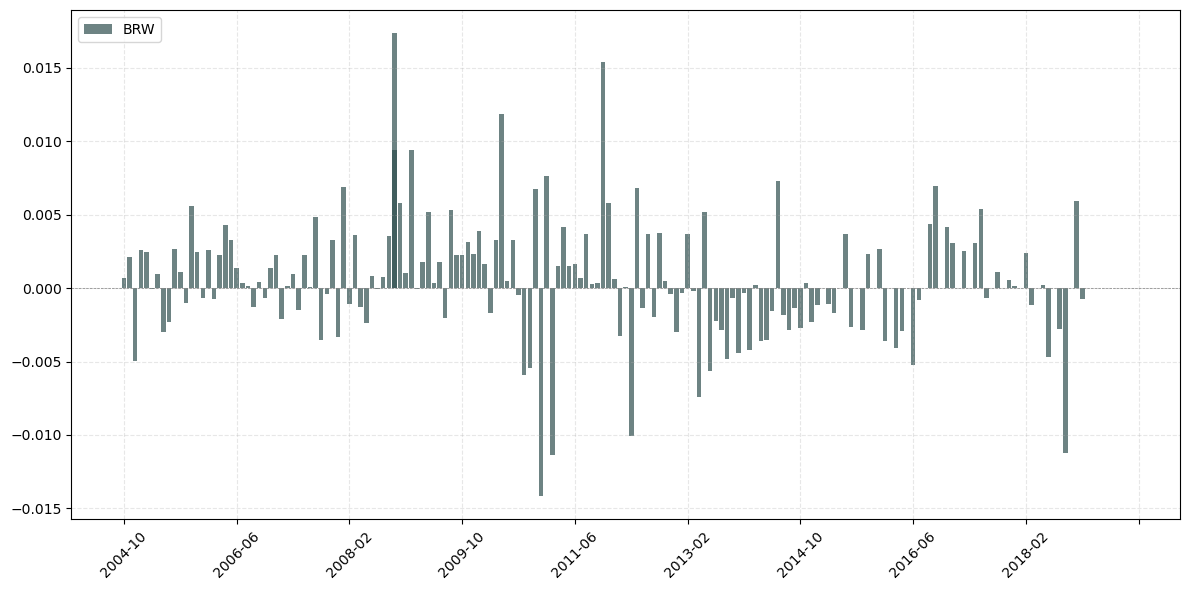

In [173]:
# Seus dados
mdate_values = data_monthly["mdate"]
new_shock_values = data_monthly["BRW_daily"]

# Configuração do estilo do gráfico
plt.figure(figsize=(12, 6))
plt.bar(mdate_values, new_shock_values, color='DarkSlateGray', alpha=0.7, label='BRW')

# Comentando as linhas relacionadas ao gráfico de linha
# plt.plot(mdate_values, new_shock_values, color='DarkSlateGray', linewidth=2, label='BRW')
# plt.title("BRW Shock - Brazil")
# plt.xlabel("Data")
# plt.ylabel("Valor do Choque")

plt.grid(True, linestyle='--', alpha=0.3)
plt.legend(loc='upper left')



# Personalização do eixo x
ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins=12))
plt.xticks(rotation=45)

# Adicionando grade horizontal
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)

# Ajustando margens e espaçamento
plt.tight_layout()

# Exportar o gráfico como um arquivo PNG
plt.savefig('brw_shock_bar_graph.png', dpi=300, bbox_inches='tight')


# Exibindo o gráfico
plt.show()
